# Calculating realized volatility over uniswap pools

The general intention here os to find an approach that can be used to calculate realized volatility
inside a ZkVM minimizing proof generation time.



First, parse the data in the `output` folder. Inside `/files`, there are the events
of 10,000 blocks. The files first need to be parsed for the `amount0` and `amount1` values.

All the `amount0` and `amount1` are pairs, where when one is positive the other is negative. The positive value will
be token being sent to the pool and the negative value is the token being extracted from the pool. Which means that
the positive was used to buy the negative. For example:

```
{"evt_tx_hash":"269b472f4e3f12475c8c87a2446377ab277bbdb083cd1b90184ca140869d3d14","evt_index":125,"evt_block_time":"2022-02-23T03:37:33Z","evt_block_number":14259969,"sender":[104,179,70,88,51,251,114,167,14,205,244,133,224,228,199,189,134,101,252,69],"recipient":[104,179,70,88,51,251,114,167,14,205,244,133,224,228,199,189,134,101,252,69],"amount0":"600000000","amount1":"-228943146269552415","sqrt_price_x96":"1548018970258445765029698839921509","liquidity":"24397164349123642323","tick":197612}
```

The transaction above means that the `amount0` (which is USDC) bought the `amount1` (ETH). Since this is ETH/USDC pool it is safe to assume whenever
the `amount` is positive it means a buy of ETH with USDC and whenever it is negative it means a sell. 


The general calculation for realized volatility over the uniswap data goes as follows:

First, pick the closing prices for the days, to calculate the volatility based on them:

In [2]:
import os
import json

def parse_json_file(file_path):
    lines = []
    with open(file_path, 'r') as file:
        for line in file:
            try:
                json_obj = json.loads(line)
                lines.append(json_obj)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON in file {file}: {e}")
    return lines



def parse_jsonl_files_in_folder(folder_path):
    files = os.listdir(folder_path)
    
    jsonl_files = sorted([f for f in files if f.endswith('.jsonl')])
    
    for jsonl_file in jsonl_files:
        file_path = os.path.join(folder_path, jsonl_file)
        parse_json_file(file_path)


folder_path = '../output/files'
parse_jsonl_files_in_folder(folder_path)

The price is also calculated and set into the data frame below:

In [4]:
import pandas as pd

json_data = parse_json_file('../output/files/0014250000-0014260000.jsonl')

df = pd.DataFrame(json_data)



# Convert USDC and ETH to floats
df['USDC_float'] = abs(df['amount0'].astype(float) / 10**6)
df['ETH_float'] = abs(df['amount1'].astype(float) / 10**18)
df['price'] = df['USDC_float'] / df['ETH_float']

df.head(3)

,evt_tx_hash,evt_index,evt_block_time,evt_block_number,sender,recipient,amount0,amount1,sqrt_price_x96,liquidity,tick,USDC_float,ETH_float,price
0,fcc3ee07bf8d919ab9de764f18bc5ef418856a39f185c2...,2,2022-02-21T14:37:39Z,14250006,"[104, 179, 70, 88, 51, 251, 114, 167, 14, 205,...","[104, 179, 70, 88, 51, 251, 114, 167, 14, 205,...",10478339758,-3884917900821301808,1525917532358317971760838574935194,24251487342182036943,197325,10478.339758,3.884918,2697.184349
1,bc79ade25faa4a0265525b01f78d7a2fc3f7b3a57b50ea...,437,2022-02-21T14:37:54Z,14250010,"[104, 179, 70, 88, 51, 251, 114, 167, 14, 205,...","[211, 78, 72, 85, 20, 106, 192, 198, 208, 228,...",4340404907,-1609216608786697661,1525912275143648921512703657856255,24251487342182036943,197325,4340.404907,1.609217,2697.216076
2,c52492625f987f9e9e9307c7563888f74497f7bbb3d64e...,634,2022-02-21T14:38:33Z,14250012,"[104, 179, 70, 88, 51, 251, 114, 167, 14, 205,...","[104, 179, 70, 88, 51, 251, 114, 167, 14, 205,...",750000000,-278063361874639352,1525911366727232516908683992960707,24251487342182036943,197325,750.000000,0.278063,2697.226974


It is possible to filter the "closing prices" of each day in the following manner. Although this might not be a good metric for
DeFi protocols, the closing prices are common when calculating realized volatility in markets.

In [7]:
# Convert evt_block_time to datetime format
df['evt_block_time'] = pd.to_datetime(df['evt_block_time'])

# Extract date part for grouping
df['date'] = df['evt_block_time'].dt.date

# Group by the date and get the last entry for each group
last_of_day = df.sort_values('evt_block_time').groupby('date').tail(1)

# Drop the extra 'date' column if not needed
last_of_day = last_of_day.drop(columns=['date'])

#Display the result


In [10]:
last_of_day

,evt_tx_hash,evt_index,evt_block_time,evt_block_number,sender,recipient,amount0,amount1,sqrt_price_x96,liquidity,tick,USDC_float,ETH_float,price
2673,927e6cd3cdc5b27608e4128cc849b91836680f1df9acbe...,131,2022-02-21 23:59:35+00:00,14252517,"[229, 146, 66, 122, 10, 236, 233, 45, 227, 237...","[86, 23, 138, 13, 95, 48, 27, 175, 108, 243, 2...",-882203393,343706495502099419,1563438046162708357428051241365555,20385838879530020901,197811,882.203393,0.343706,2566.734713
8637,e0dc30569d2bf3dc50b8ae08a965e6ec8cac25f4cc5bbe...,143,2022-02-22 23:58:59+00:00,14258980,"[104, 179, 70, 88, 51, 251, 114, 167, 14, 205,...","[104, 179, 70, 88, 51, 251, 114, 167, 14, 205,...",2640159594,-1000000000000000000,1542313422716743298605178372950883,24450300144566448723,197539,2640.159594,1.000000,2640.159594
9244,6a000661fe8aac26f5ad3bdab38041af7505c1e5e7f312...,179,2022-02-23 03:41:30+00:00,14259989,"[222, 241, 192, 222, 217, 190, 199, 241, 161, ...","[222, 241, 192, 222, 217, 190, 199, 241, 161, ...",15583247606,-5946204934447553997,1548019498567951914845772532715632,24397164349123642323,197612,15583.247606,5.946205,2620.704765


A metric that should be more common for DeFi would be to calculated the closing price for each block, like below:

In [11]:
df_sorted = df.sort_values(by=['evt_block_number', 'evt_index'])
# Group by evt_block_number and select the last row in each group
# assuming the ordering, this should return always the latest price in the block
closing_prices = df_sorted.groupby('evt_block_number').tail(1)

In [13]:
closing_prices['price']

0       2697.184349
1       2697.216076
2       2697.226974
3       2697.237143
7       2700.037218
           ...     
9240    2618.119104
9241    2618.076657
9242    2618.044571
9243    2620.668579
9244    2620.704765
Name: price, Length: 5146, dtype: float64

In [25]:
# Calculate returns
Pt = closing_prices['price'][1:].values

In [26]:
Pt

array([2697.21607601, 2697.22697353, 2697.23714317, ..., 2618.04457103,
       2620.66857869, 2620.70476511])

In [23]:
Pt_1 = closing_prices['price'][:-1].values

In [27]:
Pt/Pt_1

array([1.00001176, 1.00000404, 1.00000377, ..., 0.99998774, 1.00100228,
       1.00001381])

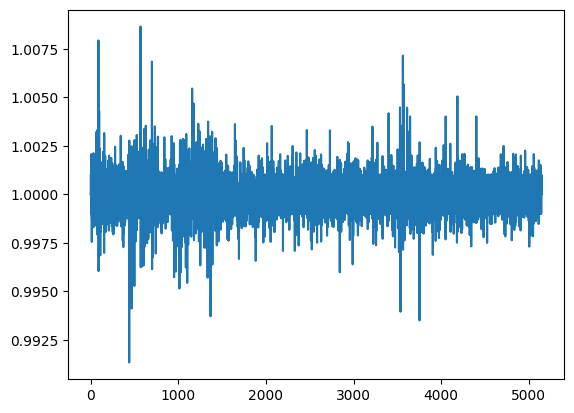

In [31]:
import matplotlib.pyplot as plt

returns = Pt/Pt_1
plt.plot(returns)

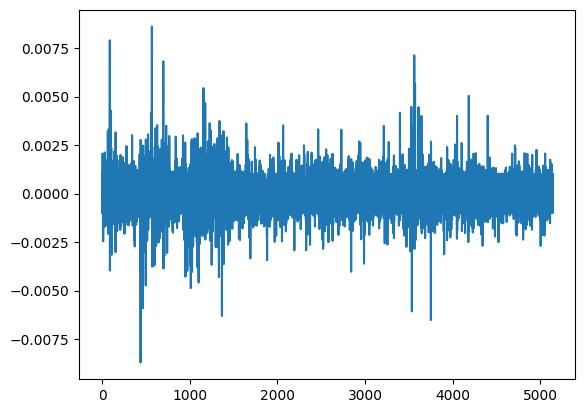

In [33]:
import numpy as np

log_returns = np.log(returns)
plt.plot(log_returns)

In [35]:
realized_volatility = np.std(log_returns)
realized_volatility


0.0010845364533086516

With all the closing prices, we can visualize the volatility for the blocks. The volatility calculation below can be summed up as follows:

1. First, calculate the log returns of the prices:

$$R_t = \ln\left(\frac{P_t}{P_{t-1}}\right)$$

Where P are the prices. So, R is calculated based on a price and another price in a previous timeframe.



Then to calculate the volatility:

$$Vol =100 \sqrt{ \frac{m}{n} \sum_{t=1}^{n} R_t^2}$$


It uses the log returns to calculate the volatility. It is normal to have another fraction multiplying the sum, to define a standardization of the timeframes. It is common to define in terms of years. For example, the number of trading days in a year (m) divided by the number of trading days in the timeframe (n). This won't work right with timeframe on-chain, because everyday is a trading day. 

Maybe these are other good candidates for more convenient for  DeFi timeframes?




(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

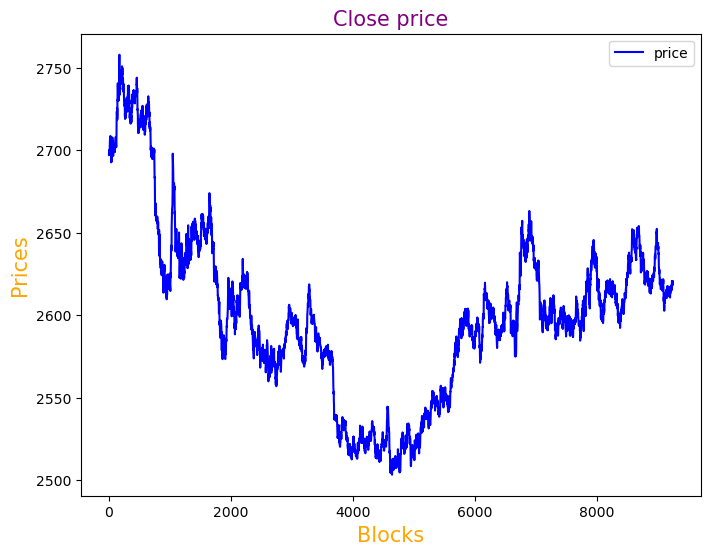

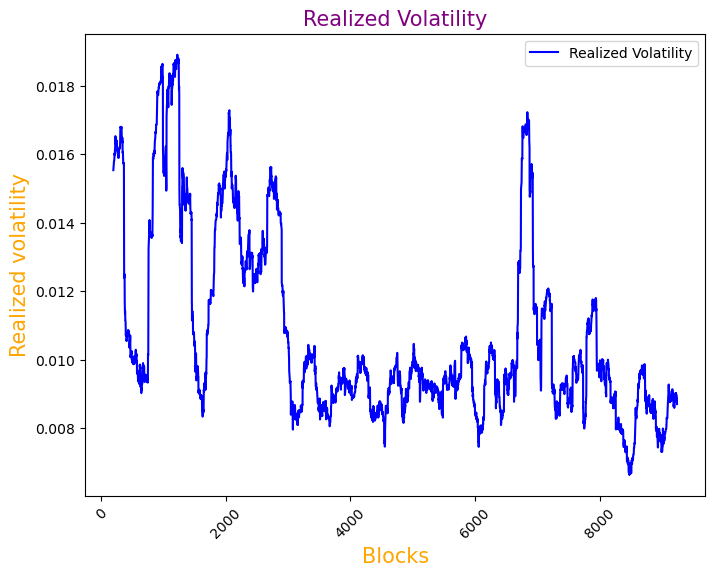

In [111]:
import numpy as np
import matplotlib.pyplot as plt

# compute log returns
closing_prices = closing_prices.assign(Log_Ret=np.log(closing_prices['price'] / closing_prices['price'].shift(1)))
closing_prices.shape

 
# Compute Volatility using the pandas rolling standard deviation function
closing_prices['Realized Volatility'] = closing_prices['Log_Ret'].rolling(window=100).std() * np.sqrt(100)


# Plot the price series and the Volatility
closing_prices[['price']].plot(subplots=True, color='blue',figsize=(8, 6))
plt.title('Close price', color='purple', size=15)

plt.xlabel('Blocks', {'color': 'orange', 'fontsize':15})
plt.ylabel('Prices', {'color': 'orange', 'fontsize':15})

closing_prices[['Realized Volatility']].plot(subplots=True, color='blue',figsize=(8, 6))
plt.title('Realized Volatility', color='purple', size=15)


# Setting axes labels for realized volatility plot

plt.xlabel('Blocks', {'color': 'orange', 'fontsize':15})

plt.ylabel('Realized volatility', {'color': 'orange', 'fontsize':15})


# Rotating the values along x-axis to 45 degrees
plt.xticks(rotation=45)

 


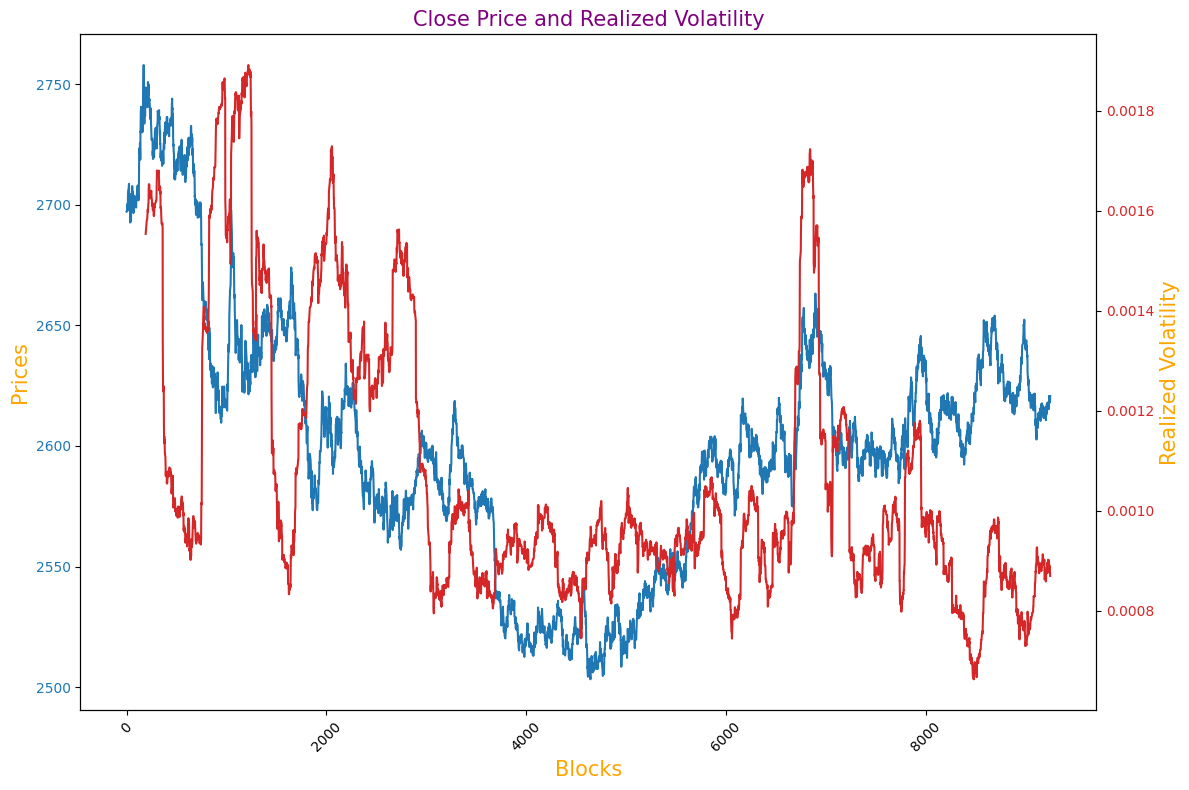

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# compute log returns
closing_prices = closing_prices.assign(Log_Ret=np.log(closing_prices['price'] / closing_prices['price'].shift(1)))
closing_prices.shape

 
# Compute Volatility using the pandas rolling standard deviation function
closing_prices['Realized Volatility'] = closing_prices['Log_Ret'].rolling(window=100).std()


# Plotting
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plotting the price series
color = 'tab:blue'
ax1.set_xlabel('Blocks', color='orange', fontsize=15)
ax1.set_ylabel('Prices', color='orange', fontsize=15)
ax1.plot(closing_prices.index, closing_prices['price'], color=color)
ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Close Price and Realized Volatility', color='purple', size=15)

# Creating a second y-axis for the realized volatility
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Realized Volatility', color='orange', fontsize=15)
ax2.plot(closing_prices.index, closing_prices['Realized Volatility'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Show plot
fig.tight_layout()
plt.show()

 


## Possible usages of this calculation inside smart contracts

If we get proofs of the realized volatility onchain, how can we use them in the uniswap v4 hooks?

These are some aspects I'm wondering about:

- [Volatility Arbitrage](https://quantra.quantinsti.com/glossary/Volatility-Arbitrage)
- rearranging LP liquidity provision based on the volatilty of many UniswapV3Pools.